# Задание для стажера по направлению «Количественный анализ (Quantitative Research)»

In [17]:
import pandas as pd
import os
import pandas as pd
import datetime
import requests
%config InlineBackend.figure_format = 'svg'
import shutil
import matplotlib.pyplot as plt
import numpy as np
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from sklearn.covariance import LedoitWolf


## 1) Загрузите котировки акций-голубых фишек российского рынка за последние полгода. 

### Анализ акций-голубых фишек

По версии Московской биржы в список голубых фишек входят:

In [18]:
blue_chips = pd.DataFrame([
    {"ticker": "CHMF", "name": "Северсталь",        "finam_id": 16136},
    {"ticker": "GAZP", "name": "Газпром",           "finam_id": 16842},
    {"ticker": "GMKN", "name": "Норильский никель", "finam_id": 795},
    {"ticker": "HEAD", "name": "Headhunter",        "finam_id": 5287020},
    {"ticker": "LKOH", "name": "Лукойл",            "finam_id": 8},
    {"ticker": "MOEX", "name": "Московская биржа",  "finam_id": 152798},
    {"ticker": "NLMK", "name": "Новолипецкий МК",   "finam_id": 17046},
    {"ticker": "NVTK", "name": "Новатэк",           "finam_id": 17370},
    {"ticker": "PLZL", "name": "Полюс",             "finam_id": 17123},
    {"ticker": "ROSN", "name": "Роснефть",          "finam_id": 17273},
    {"ticker": "SBER", "name": "Сбербанк",          "finam_id": 3},
    {"ticker": "SNGS", "name": "Сургутнефтегаз",    "finam_id": 4},
    {"ticker": "T",    "name": "Т-Техно ао",        "finam_id": 5428482},
    {"ticker": "TATN", "name": "Татнефть",          "finam_id": 825},
    {"ticker": "YDEX", "name": "Яндекс",            "finam_id": 5239179}
])
blue_chip_stocks = sorted(blue_chips['ticker'].tolist())
print(blue_chips)

   ticker               name  finam_id
0    CHMF         Северсталь     16136
1    GAZP            Газпром     16842
2    GMKN  Норильский никель       795
3    HEAD         Headhunter   5287020
4    LKOH             Лукойл         8
5    MOEX   Московская биржа    152798
6    NLMK    Новолипецкий МК     17046
7    NVTK            Новатэк     17370
8    PLZL              Полюс     17123
9    ROSN           Роснефть     17273
10   SBER           Сбербанк         3
11   SNGS     Сургутнефтегаз         4
12      T         Т-Техно ао   5428482
13   TATN           Татнефть       825
14   YDEX             Яндекс   5239179


### Загрузка данных

#### Загрузка данных c FINAM

Мне удобнее использовать данные с `FINAM`

Так как нужны данные за последние полгода, то 
```
start_date = "2024-10-25"
end_date = "2025-04-25"
```

In [19]:
def process_stock_dfs(df):
    df = df.copy()
    required_columns = ['<DATE>', '<TIME>', '<OPEN>', '<HIGH>', '<LOW>', '<CLOSE>', '<VOL>']
    for col in required_columns:
        if col not in df.columns:
            raise ValueError(f"Missing required column: {col}")
    df['<DATE>'] = df['<DATE>'].astype(str)
    df['<TIME>'] = df['<TIME>'].astype(str).str.zfill(6)
    df['<TIME>'] = df['<TIME>'].replace('0', '000000')
    if df['<DATE>'].str.len().max() == 8:
        date_format = '%Y%m%d%H%M%S'
    elif df['<DATE>'].str.len().max() == 6:
        date_format = '%y%m%d%H%M%S'
    else:
        raise ValueError("Unexpected date format in <DATE> column.")
    try:
        df['datetime'] = pd.to_datetime(
            df['<DATE>'] + df['<TIME>'],
            format=date_format,
            errors='coerce'
        )
    except Exception as e:
        print(f"Error parsing datetime: {e}")
        return None
    return df.dropna(subset=['datetime']).drop(columns=['<DATE>', '<TIME>']).rename(columns={
            '<OPEN>': 'open',
            '<HIGH>': 'high',
            '<LOW>': 'low',
            '<CLOSE>': 'close',
            '<VOL>': 'volume'
        }).sort_values('datetime')

In [20]:
# Функция скачивания с финама
def download_finam_data(ticker="SBER", start_date="2023-01-01", end_date="2024-01-01", timeframe=6, output_file="sber.csv", em=1, output_folder = "research/res/5min/test"):
    start_dt = datetime.datetime.strptime(start_date, "%Y-%m-%d")
    end_dt = datetime.datetime.strptime(end_date, "%Y-%m-%d")
    current_dt = start_dt
    all_files = []
    os.makedirs(output_folder, exist_ok=True)
    while current_dt < end_dt:
        next_dt = min(current_dt + datetime.timedelta(days=90), end_dt)
        filename = f"{output_folder}/{ticker}_{current_dt.strftime('%Y%m%d')}_{next_dt.strftime('%Y%m%d')}.csv"
        all_files.append(filename)
        params = {
            "market": 1,
            "em": em,
            "code": ticker,
            "apply": 0,
            "df": current_dt.day,
            "mf": current_dt.month - 1,
            "yf": current_dt.year,
            "dt": next_dt.day,
            "mt": next_dt.month - 1,
            "yt": next_dt.year,
            "p": timeframe,
            "f": "data",
            "e": ".csv",
            "cn": ticker,
            "dtf": 1,
            "tmf": 1,
            "MSOR": 0,
            "mstimever": 1,
            "sep": 1,
            "sep2": 1,
            "datf": 5,
            "at": 1
        }
        url = "http://export.finam.ru/export9.out"
        response = requests.get(url, params=params)
        if response.status_code == 200:
            with open(filename, "w", encoding="utf-8") as file:
                file.write(response.text)
            print(f"Данные сохранены в {filename}")
        else:
            print(f"Ошибка загрузки данных ({response.status_code}) для периода {current_dt.strftime('%Y-%m-%d')} - {next_dt.strftime('%Y-%m-%d')}")
        current_dt = next_dt + datetime.timedelta(days=1)
    combined_file = f"{output_folder}/{output_file}"
    all_dataframes = []
    for f in all_files:
        if os.path.exists(f):
            df = pd.read_csv(f, sep=",")
            if "<DATE>" in df.columns:
                df["<DATE>"] = df["<DATE>"].astype(str)
            all_dataframes.append(df)
    if all_dataframes:
        combined_data = pd.concat(all_dataframes, ignore_index=True)
        combined_data = process_stock_dfs(combined_data)
        combined_data.drop_duplicates(subset="datetime", inplace=True)
        combined_data.to_csv(combined_file, index=False, sep=",")
        print(f"\nИтоговый файл сохранён в {combined_file}")
    else:
        print("Не удалось объединить файлы: данные не загружены.")
    for f in all_files:
        if os.path.exists(f):
            os.remove(f)
    print(f"Удалены все промежуточные файлы для тикера {ticker}")

In [21]:
# Цикл по всем тикерам
start_date = "2024-10-25"
end_date = "2025-04-25"
timeframe = 8
for idx, row in blue_chips.iterrows():
    ticker = row['ticker']
    output_file = f"{ticker}.csv"
    output_folder = f"res/1d/train/{ticker}"
    if (os.path.exists(output_folder) and os.path.isdir(output_folder)):
        print(f"-> Уже скачано {ticker}")
        continue
    print(f"-> Скачивание данных для {ticker}")
    download_finam_data(ticker=ticker, start_date=start_date, end_date=end_date, timeframe=timeframe, output_file=output_file, em = row['finam_id'], output_folder=output_folder)

-> Уже скачано CHMF
-> Уже скачано GAZP
-> Уже скачано GMKN
-> Уже скачано HEAD
-> Уже скачано LKOH
-> Уже скачано MOEX
-> Уже скачано NLMK
-> Уже скачано NVTK
-> Уже скачано PLZL
-> Уже скачано ROSN
-> Уже скачано SBER
-> Уже скачано SNGS
-> Уже скачано T
-> Уже скачано TATN
-> Уже скачано YDEX


#### Осмотр скаченных данных

In [22]:
# Все активы
assets = {ticker: pd.read_csv(f"res/1d/train/{ticker}/{ticker}.csv") for ticker in blue_chip_stocks}
# Для примера['2025-03-24', '2025-03-25', '2025-03-26']
assets['MOEX'].head()

open    high     low   close    volume    datetime
0  201.99  205.74  198.38  200.11  12034040  2024-10-25
1  199.10  200.83  190.95  194.90   8145540  2024-10-28
2  194.90  196.14  190.95  194.88   5565190  2024-10-29
3  195.47  197.39  191.17  191.80   4305580  2024-10-30
4  192.44  193.61  185.80  187.66   6197910  2024-10-31

## 2) Скорректируйте котировки на сплиты.

### Рассмотрим были ли сплиты у акций

Как можно посмотреть были ли сплиты у акции:
- в истории инструмента на разных сайтах
- в новостях
- визуально, заметив резкое падение

Я просмотрел истории активов за последние полгода - были ли?
<table style="width: 100%; border: none;">
    <tr>
        <th style="text-align: center; border: none;">Тикер</th>
        <th style="text-align: center; border: none;">CHMF</th>
        <th style="text-align: center; border: none;">GAZP</th>
        <th style="text-align: center; border: none;">GMKN</th>
        <th style="text-align: center; border: none;">HEAD</th>
        <th style="text-align: center; border: none;">LKOH</th>
    </tr>
    <tr>
        <td style="text-align: center; border: none;">Сплит</td>
        <td style="text-align: center; border: none;">
            -</td>
        <td style="text-align: center; border: none;">
            -</td>
        <td style="text-align: center; border: none;">
            -</td>
        <td style="text-align: center; border: none;">
            -</td>
        <td style="text-align: center; border: none;">
            -</td>
    </tr>
</table>

<table style="width: 100%; border: none;">
    <tr>
        <th style="text-align: center; border: none;">Тикер</th>
        <th style="text-align: center; border: none;">MOEX</th>
        <th style="text-align: center; border: none;">NLMK</th>
        <th style="text-align: center; border: none;">NVTK</th>
        <th style="text-align: center; border: none;">PLZL</th>
        <th style="text-align: center; border: none;">ROSN</th>
    </tr>
    <tr>
        <td style="text-align: center; border: none;">Сплит</td>
        <td style="text-align: center; border: none;">—</td>
        <td style="text-align: center; border: none;">—</td>
        <td style="text-align: center; border: none;">—</td>
        <td style="text-align: center; border: none;">Был сплит</td>
        <td style="text-align: center; border: none;">—</td>
    </tr>
</table>

<table style="width: 100%; border: none;">
    <tr>
        <th style="text-align: center; border: none;">Тикер</th>
        <th style="text-align: center; border: none;">SBER</th>
        <th style="text-align: center; border: none;">SNGS</th>
        <th style="text-align: center; border: none;">T</th>
        <th style="text-align: center; border: none;">TATN</th>
        <th style="text-align: center; border: none;">YDEX</th>
    </tr>
    <tr>
        <td style="text-align: center; border: none;">Сплит</td>
        <td style="text-align: center; border: none;">—</td>
        <td style="text-align: center; border: none;">—</td>
        <td style="text-align: center; border: none;">—</td>
        <td style="text-align: center; border: none;">—</td>
        <td style="text-align: center; border: none;">—</td>
    </tr>
</table>

Итог: только у акций Полюса был сплит 1:10 https://www.forbes.ru/investicii/533593-polus-zaversil-droblenie-akcij-s-koefficientom-1-10

Однако резких понижений стоимости акции нет, значит котировки уже скорректированы на сплиты! Также в новостных записях написано, что акции до сплита стоили 17 тыс, на графике цена в 10 раз меньше

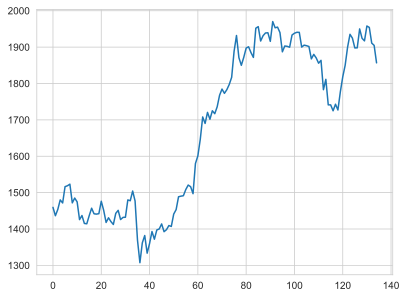

In [23]:
plt.plot(assets['PLZL']['close'])
plt.show()

### Создадим общий датасет цен закрытия

Очевидно, что если был сплит, то в эти дни акции не торговались, а значит в данных будут Nan. 

Чтобы от них избавиться можно:
- заполнить данные последней ценой - это плохо скажется на доходности
- заполнить удалить дни без торгов - это образует в датасете дыры
- интерполировать пропущенные значения - отличное решение, в этом случае отражается рыночная реальность


In [24]:
df = pd.concat(
    [
        df.set_index(pd.to_datetime(df['datetime']))['close'].rename(ticker)
        for ticker, df in assets.items()
    ],
    axis=1
).sort_index()
df.isna().sum()

CHMF    0
GAZP    0
GMKN    0
HEAD    0
LKOH    0
MOEX    0
NLMK    0
NVTK    0
PLZL    3
ROSN    0
SBER    0
SNGS    0
T       0
TATN    0
YDEX    0
dtype: int64

Действительно у Полюса отсутсвуют 3 торговых дня `['2025-03-24', '2025-03-25', '2025-03-26']` - как раз во время проведения сплита. Интерполируем!!!

In [25]:
df = df.interpolate()
df['PLZL']['2025-03-23':'2025-03-27']

datetime
2025-03-24    1893.175
2025-03-25    1884.650
2025-03-26    1876.125
2025-03-27    1867.600
Name: PLZL, dtype: float64

## 3) Постройте Mean-Variance Portfolio из акций, загруженных ранее, и оцените его динамику.

### Вычисление доходностей

Я буду использовать лог-доходности, потому что удобнее полагать, что активы подчиняются геометрическому броуновскому движению, а также лог-доходности стабильнее.

In [26]:
df_returns = df.copy().apply(
    lambda x: np.log(x / x.shift(1)) if pd.api.types.is_numeric_dtype(x) else x
).dropna()

returns = np.stack(df_returns.apply(
        lambda row: row.to_numpy(),
        axis=1
))
returns

array([[-0.0368533 , -0.06307593, -0.05309188, ..., -0.03656753,
        -0.05383431, -0.02415162],
       [ 0.02117431,  0.00877059,  0.03717748, ...,  0.02864917,
         0.00881063,  0.00399947],
       [-0.01737305, -0.01737642, -0.02230425, ..., -0.02071518,
        -0.01639834, -0.01285502],
       ...,
       [-0.02839571, -0.01123529, -0.01955587, ..., -0.01898128,
        -0.01402829, -0.01792474],
       [ 0.0084357 ,  0.00632671, -0.00525671, ..., -0.00080914,
        -0.00462362,  0.00186524],
       [ 0.0321453 ,  0.04034229,  0.03334506, ...,  0.02229019,
         0.04114055,  0.01812041]])

### Вычисление матрицы ковариации

In [27]:
df_cov = df_returns.cov()
cov_matrix = df_cov.to_numpy()
df_cov

CHMF      GAZP      GMKN      HEAD      LKOH      MOEX      NLMK  \
CHMF  0.000831  0.000584  0.000599  0.000477  0.000340  0.000421  0.000670   
GAZP  0.000584  0.000714  0.000549  0.000319  0.000297  0.000390  0.000524   
GMKN  0.000599  0.000549  0.000683  0.000356  0.000284  0.000332  0.000555   
HEAD  0.000477  0.000319  0.000356  0.000993  0.000354  0.000236  0.000363   
LKOH  0.000340  0.000297  0.000284  0.000354  0.000288  0.000195  0.000304   
MOEX  0.000421  0.000390  0.000332  0.000236  0.000195  0.000424  0.000374   
NLMK  0.000670  0.000524  0.000555  0.000363  0.000304  0.000374  0.000680   
NVTK  0.000598  0.000564  0.000510  0.000374  0.000332  0.000389  0.000536   
PLZL  0.000101  0.000147  0.000111  0.000022  0.000073  0.000136  0.000123   
ROSN  0.000443  0.000409  0.000398  0.000256  0.000245  0.000260  0.000422   
SBER  0.000447  0.000408  0.000397  0.000256  0.000248  0.000282  0.000413   
SNGS  0.000430  0.000416  0.000397  0.000295  0.000248  0.000276  0.000409   
T     0.000544  0.000508  0.000514  0.000299  0.000287  0.000349  0.000514   
TATN  0.000404  0.000386  0.000383  0.000273  0.000227  0.000249  0.000370   
YDEX  0.000513  0.000471  0.000463  0.000306  0.000263  0.000331  0.000476   

          NVTK      PLZL      ROSN      SBER      SNGS         T      TATN  \
CHMF  0.000598  0.000101  0.000443  0.000447  0.000430  0.000544  0.000404   
GAZP  0.000564  0.000147  0.000409  0.000408  0.000416  0.000508  0.000386   
GMKN  0.000510  0.000111  0.000398  0.000397  0.000397  0.000514  0.000383   
HEAD  0.000374  0.000022  0.000256  0.000256  0.000295  0.000299  0.000273   
LKOH  0.000332  0.000073  0.000245  0.000248  0.000248  0.000287  0.000227   
MOEX  0.000389  0.000136  0.000260  0.000282  0.000276  0.000349  0.000249   
NLMK  0.000536  0.000123  0.000422  0.000413  0.000409  0.000514  0.000370   
NVTK  0.000783  0.000137  0.000426  0.000447  0.000449  0.000550  0.000424   
PLZL  0.000137  0.000354  0.000116  0.000110  0.000129  0.000154  0.000125   
ROSN  0.000426  0.000116  0.000467  0.000331  0.000329  0.000393  0.000326   
SBER  0.000447  0.000110  0.000331  0.000395  0.000308  0.000427  0.000331   
SNGS  0.000449  0.000129  0.000329  0.000308  0.000501  0.000392  0.000319   
T     0.000550  0.000154  0.000393  0.000427  0.000392  0.000607  0.000373   
TATN  0.000424  0.000125  0.000326  0.000331  0.000319  0.000373  0.000493   
YDEX  0.000521  0.000130  0.000364  0.000385  0.000371  0.000496  0.000349   

          YDEX  
CHMF  0.000513  
GAZP  0.000471  
GMKN  0.000463  
HEAD  0.000306  
LKOH  0.000263  
MOEX  0.000331  
NLMK  0.000476  
NVTK  0.000521  
PLZL  0.000130  
ROSN  0.000364  
SBER  0.000385  
SNGS  0.000371  
T     0.000496  
TATN  0.000349  
YDEX  0.000508

### Mean-Variance Portfolio

#### Построение `Efficient Frontier` для портфеля

**Постановка задачи Марковица (Mean-Variance Optimization)**
Есть $n$ активов. Пусть:
- $r = (r_1, r_2, \dots, r_n)^\top$ — вектор средних доходностей активов,
- $\Sigma$ — ковариационная матрица доходностей,
- $w = (w_1, w_2, \dots, w_n)^\top$ — веса активов в портфеле, $\sum w_i = 1$

Тогда требуется максимизировать доходность портфеля $\mu = w^\top r$ (заданную весами активов) и при этом минимизировать риск - волатильность $\sigma_p^2 = w^\top\Sigma w$. Требуется найти такой вектор весов $ w $, который минимизирует дисперсию (риск) портфеля при заданной ожидаемой доходности $ \mu $:

$$
\begin{aligned}
\min_w \quad & w^\top \Sigma w \\
\text{при условиях:} \quad & w^\top \mathbf{1} = 1 \\
& w^\top r = \mu
\end{aligned}
$$


**Метод Лагранжа**

Определив функцию Лагранжа:

$$
\mathcal{L}(w, \lambda, \nu) = w^\top \Sigma w - \lambda (w^\top \mathbf{1} - 1) - \nu (w^\top r - \mu)
$$

Найдя градиенты по $ w, \lambda, \nu $:

$$
\begin{cases}
\nabla_w \mathcal{L} = 2\Sigma w - \lambda \mathbf{1} - \nu r = 0 \\
\frac{\partial \mathcal{L}}{\partial \lambda} = w^\top \mathbf{1} - 1 = 0 \\
\frac{\partial \mathcal{L}}{\partial \nu} = w^\top r - \mu = 0
\end{cases}
$$

Предыдущую систему можно записать в матричной форме:

$$
\begin{bmatrix}
2\Sigma & -\mathbf{1} & -r \\
\mathbf{1}^\top & 0 & 0 \\
r^\top & 0 & 0
\end{bmatrix}
\begin{bmatrix}
w \\
\lambda \\
\nu
\end{bmatrix} =
\begin{bmatrix}
0 \\
1 \\
\mu
\end{bmatrix}
$$

Решение этой системы даёт оптимальный вектор весов $ w^* $, а также значения множителей Лагранжа $ \lambda, \nu $.


**Общее аналитическое решение**

Введя обозначения:

$$
\begin{aligned}
A &= \mathbf{1}^\top \Sigma^{-1} \mathbf{1} \\
B &= \mathbf{1}^\top \Sigma^{-1} r \\
C &= r^\top \Sigma^{-1} r \\
D &= AC - B^2
\end{aligned}
$$

Тогда аналитическое решение имеет вид:

$$
w^* = \Sigma^{-1} \left[ \frac{C - \mu B}{D} \cdot \mathbf{1} + \frac{\mu A - B}{D} \cdot r \right]
$$

Минимальная дисперсия (риск) портфеля при доходности $ \mu $:

$$
\sigma^2(\mu) = \frac{A \mu^2 - 2B \mu + C}{D}
$$

Это уравнение описывает **параболу**, вдоль которой лежит эффективная граница в пространстве $(\sigma, \mu)$.


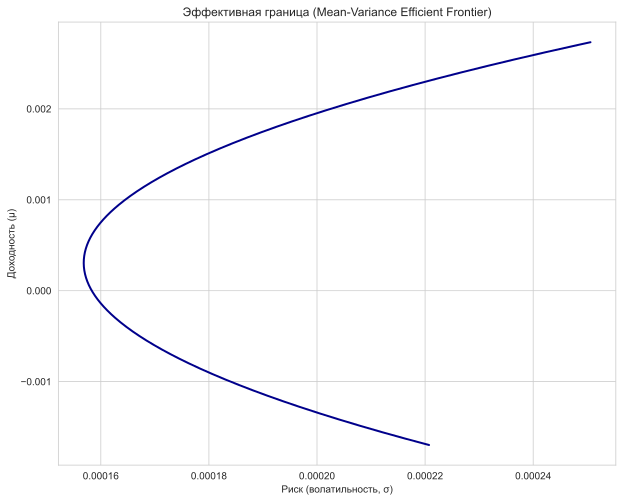

In [28]:
n = len(assets)
ones = np.ones(n)
inverse_sigma = np.linalg.inv(cov_matrix)
r = returns.mean(axis=0)

A = ones.T @ inverse_sigma @ ones
B = ones.T @ inverse_sigma @ r
C = r.T @ inverse_sigma @ r
D = A * C - B * B

def sigma_square(mu):
    return (A*mu**2 - 2*B*mu + C)/D

mu_theoretical_list = np.arange(r.min(), r.max(), 0.00001)
sigma_theoretical_list = sigma_square(mu_theoretical_list)

plt.figure(figsize=(10, 8))
plt.plot(sigma_theoretical_list, mu_theoretical_list, lw=2, color='darkblue')
plt.xlabel('Риск (волатильность, σ)')
plt.ylabel('Доходность (μ)')
plt.title('Эффективная граница (Mean-Variance Efficient Frontier)')
plt.grid(True)
plt.show()

Найдём точку (портфель) самого минимального риска: $
w^* = \Sigma^{-1} \left[ \frac{C - \mu B}{D} \cdot \mathbf{1} + \frac{\mu A - B}{D} \cdot r \right]
$

In [29]:
def get_portfolio(mu):
    return inverse_sigma @ (((C-mu*B)/D)*ones + ((mu*A-B)/D)*r)

In [30]:
sigma_theoretical_opt = np.argmin(sigma_theoretical_list)
mu_theoretical_opt = mu_theoretical_list[sigma_theoretical_opt]
w_theoretical_opt = get_portfolio(mu_theoretical_opt)
w_theoretical_opt

array([-0.11252407, -0.14197399,  0.09867389, -0.0289267 ,  0.57097868,
        0.25581302, -0.0901647 , -0.18647504,  0.30748905,  0.08241329,
        0.24923675,  0.06280219, -0.24472787,  0.0505529 ,  0.12683259])

Так... Я получил веса с отрицательными значениями. Это означает наличие short-позиций, то есть продажи некоторых активов с последующей покупкой других на вырученные средства. С точки зрения финансовой логики такие решения корректны — они обеспечивают перераспределение капитала в целях минимизации риска или максимизации доходности.

Однако на практике short-позиции могут быть ограничены или запрещены (например, регуляторно, технически или политикой инвестора). Поэтому я дополнительно рассмотрю альтернативный вариант — long-only портфель, в котором все веса ограничены снизу: $w_i \ge 0$.

Это позволит сравнить теоретически оптимальное распределение с практическим, реализуемым на рынке, и оценить, насколько сильно сказывается ограничение на результат (доходность, риск, Sharpe ratio и т.д.).

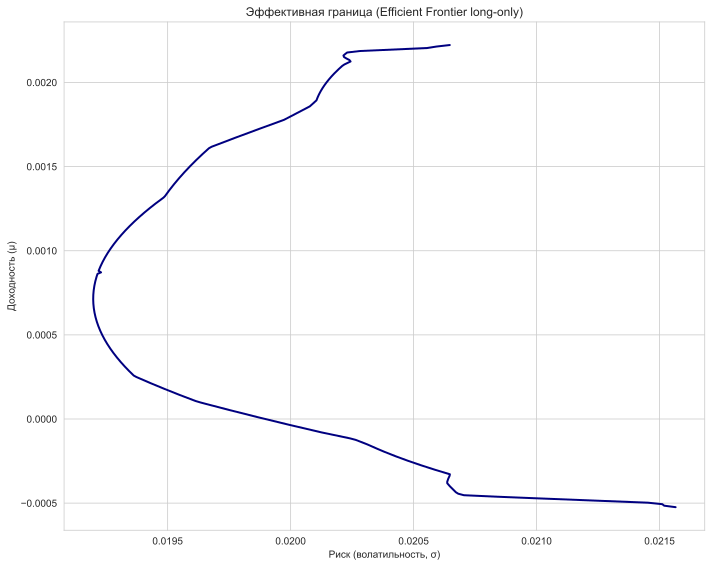

In [31]:
def portfolio_variance(w, cov):
    return w.T @ cov @ w

mu_range = np.linspace(r.min(), r.max(), 500)
bounds = [(0, 0.3) for _ in range(n)]
init_guess = np.full(n, 1/n)
sigma_practical_list, mu_practical_list, weights_dict = [], [], {}

for mu_target in mu_range:
    constraints = [
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
        {'type': 'eq', 'fun': lambda w, mu=mu_target: w @ r - mu}]
    res = minimize(
        fun=portfolio_variance,
        x0=init_guess,
        args=(cov_matrix,),
        method='SLSQP',
        bounds=bounds,
        constraints=constraints,
        options={'maxiter': 500, 'disp': False})
    if res.success:
        w_op = res.x
        risk = np.sqrt(portfolio_variance(w_op, cov_matrix))
        sigma_practical_list.append(risk)
        mu_practical_list.append(mu_target)
        weights_dict[round(risk, 6)] = w_op

plt.figure(figsize=(10, 8))
plt.plot(sigma_practical_list, mu_practical_list, lw=2, color='navy')
plt.xlabel('Риск (волатильность, σ)')
plt.ylabel('Доходность (μ)')
plt.title('Эффективная граница (Efficient Frontier long-only)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [32]:
print(f"Портфель минимального риска (σ = {round(min(sigma_practical_list), 6):.4f}):")
w_practical_opt = weights_dict[round(min(sigma_practical_list), 6)]
w_practical_opt

Портфель минимального риска (σ = 0.0192):


array([0.07610723, 0.06635438, 0.0646111 , 0.08900808, 0.07344672,
       0.07188961, 0.06684729, 0.0502559 , 0.05944216, 0.07103766,
       0.05835778, 0.07250539, 0.05446885, 0.05980087, 0.06586697])

Это уже лучше!!!!

Посмотрим в сравнении с безрисковой ставкой 21% или полугодовой ставкой лог доходностью $ 0.0008333 $

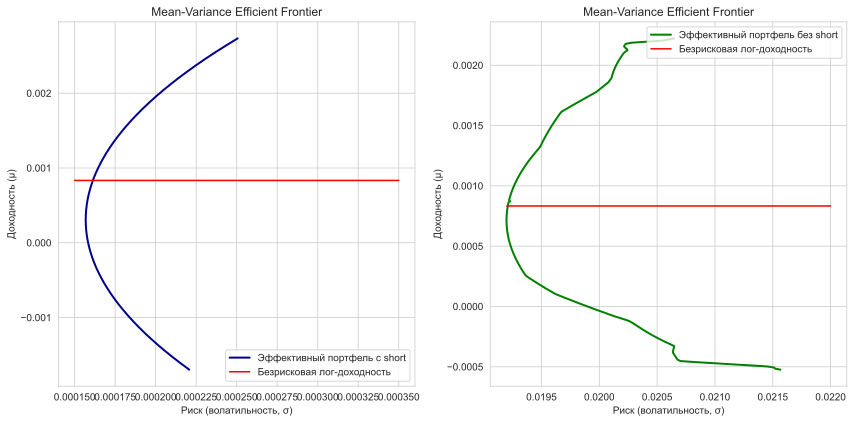

In [33]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(sigma_theoretical_list, mu_theoretical_list, lw=2, color='darkblue', label='Эффективный портфель c short')
ax1.plot(np.linspace(0.00015, 0.00035, 10), np.full(10, 0.0008333), label='Безрисковая лог-доходность', color='red')
ax1.set_xlabel('Риск (волатильность, σ)')
ax1.set_ylabel('Доходность (μ)')
ax1.set_title('Mean-Variance Efficient Frontier')
ax1.legend()
ax1.grid(True)

ax2.plot(sigma_practical_list, mu_practical_list, lw=2, color='green', label='Эффективный портфель без short')
ax2.plot(np.linspace(0.0192, 0.0220, 10), np.full(10, 0.0008333), label='Безрисковая лог-доходность', color='red')
ax2.set_xlabel('Риск (волатильность, σ)')
ax2.set_ylabel('Доходность (μ)')
ax2.set_title('Mean-Variance Efficient Frontier')
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()

Ниже красной линии находятся невыгодные портфели - их доходность меньше (или равна) доходности безрискового, но при этом несёт риск. Это также заметно ниже при их сравнении по основным метрикам

#### Сранение динамик портфелей

**Основные метрики портфелей**

| №  | Метрика                 | Формула                                                                                                   | Что показывает |
|----|-------------------------|------------------------------------------------------------------------------------------------------------|----------------|
| 1  | **Cumulative Return**   | $ \exp\left(\sum r_t\right) - 1 $                                                                          | Общая накопленная доходность за весь период |
| 2  | **Annualized Return**   | $ \exp(\mu \cdot \text{freq}) - 1 $                                                                        | Доходность, которую портфель бы принёс за год при текущих темпах роста |
| 3  | **Volatility** | $ \sigma $                                                                       | Волатильность доходностей (риск) портфеля за период |
| 3  | **Annualized Volatility** | $ \sigma \cdot \sqrt{\text{freq}} $                                                                       | Годовая волатильность доходностей (риск) |
| 4  | **Sharpe Ratio**        | $ \frac{R_p - R_f}{\sigma_p} $                                                                             | Эффективность доходности на единицу риска |
| 5  | **Sortino Ratio**       | $ \frac{R_p - R_f}{\sigma_{\text{down}}} $                                                                 | То же, что Sharpe, но наказывает только за отрицательные колебания |
| 6  | **Max Drawdown**        | $ \min_t \left( \frac{V_t - \max_{s \le t} V_s}{\max_{s \le t} V_s} \right) $                              | Максимальное падение стоимости портфеля от пика до минимума |
| 7  | **Calmar Ratio**        | $ \equiv{\frac{\text{Annualized Return}}{\text{Max Drawdown}}}$                                                | Соотношение годовой доходности к максимальной просадке |
| 8  | **Value-at-Risk (5%)**  | $ \text{quantile}_{5\%}(r_t) $                                                                             | Потери, которые могут быть превышены с вероятностью 5% |
| 9  | **Conditional VaR (CVaR)** | $ \mathbb{E}[r_t \mid r_t \le \text{VaR}_{5\%}] $                                                      | Средние потери при условии, что случился худший сценарий (хуже VaR) |
| 10 | **Rolling Sharpe Std**  | $ \text{std} \left( \frac{\mu_t}{\sigma_t} \right) $ на окне 60 дней                                     | Стабильность эффективности портфеля во времени |
| 11 | **Skewness**            | $ \frac{\mathbb{E}[(r - \mu)^3]}{\sigma^3} $                                                              | Асимметрия доходностей: смещены ли они в сторону прибыли или убытков |
| 12 | **Kurtosis**            | $ \frac{\mathbb{E}[(r - \mu)^4]}{\sigma^4} - 3 $                                                           | «Толстохвостость» распределения доходностей, риск экстремальных событий |

Где:
- $r_t$ — логарифмическая доходность в момент времени $t$
- $\mu$ — средняя лог-доходность
- $\sigma$ — стандартное отклонение лог-доходностей
- $R_f$ — безрисковая ставка, качестве неё возьмём ключевую ставку Банка России 21% (за полгода 10.5%)
- freq — частота периодов в году (обычно 252 для дневных данных)


In [34]:
def evaluate_portfolio(weights, returns, risk_free_rate=0.0, freq=252):
    """
    Оценка портфеля на основе лог-доходностей.
    
    weights: np.array — веса активов
    returns: pd.DataFrame — лог-доходности активов
    risk_free_rate: float — безрисковая ставка (в годовых)
    freq: int — частота наблюдений (обычно 252 для дневных данных)
    """
    port_returns = returns @ weights
    port_mean = port_returns.mean()
    port_std = port_returns.std()

    # Преобразование лог-доходности в накопленную и годовую доходность
    cumulative_return = np.exp(port_returns.sum()) - 1
    annualized_return = np.exp(port_mean * freq) - 1
    annualized_vol = port_std * np.sqrt(freq)

    # Sharpe и Sortino
    sharpe_ratio = (annualized_return - risk_free_rate) / annualized_vol
    downside_returns = port_returns[port_returns < 0]
    downside_std = downside_returns.std() * np.sqrt(freq)
    sortino_ratio = (annualized_return - risk_free_rate) / downside_std if downside_std != 0 else np.nan

    # Максимальная просадка — на основе экспоненцированных кумулятивных доходностей
    cumulative = np.exp(port_returns.cumsum())
    peak = cumulative.max()
    drawdown = (cumulative - peak) / peak
    max_drawdown = drawdown.min()
    calmar_ratio = annualized_return / abs(max_drawdown) if max_drawdown != 0 else np.nan

    # VaR и CVaR (лог-доходности)
    confidence_level = 0.05
    var = np.percentile(port_returns, 100 * confidence_level)
    cvar = port_returns[port_returns <= var].mean()
    
    # Скользящий Sharpe (log returns)
    def rolling_std(data, window):
        return np.array([data[i-window+1:i+1].std() for i in range(window-1, len(data))])
    
    # Скос и эксцесс
    skewness = skew(port_returns)
    kurt = kurtosis(port_returns)

    return {
        "Cumulative Return": cumulative_return,
        "Annualized Return": annualized_return,
        "Volatility":    port_std,
        "Annualized Volatility": annualized_vol,
        "Sharpe Ratio": sharpe_ratio,
        "Sortino Ratio": sortino_ratio,
        "Max Drawdown": max_drawdown,
        "Calmar Ratio": calmar_ratio,
        "VaR (5%)": var,
        "CVaR (5%)": cvar,
        "Rolling Sharpe Std": rolling_std(port_returns, 30).mean(),
        "Skewness": skewness,
        "Kurtosis": kurt
    }

Какие портфели нужно сравнить? Как я уже показал, выгодные портфели находятся выше красной линии. Далее выбор портфеля зависит от предпочтений владельца портфеля.

Предположим я хочу самый оптимальный по риску портфель, и при этом с log-доходностью 0.0015, значит с доходностью 45% годовых.

Сравним 5 портфелей:
- портфель с минимальным риском с разрешенными 'short' позициями - `Portfolio A`
- портфель с минимальным риском с заперщёнными 'short' позициями - `Portfolio B`
- равновесный портфель - `Portfolio С`
- портфель log-доходностью 0.002 c разрешенными 'short' позициями - `Portfolio D`
- портфель log-доходностью 0.002 c заперщёнными 'short' позициями - `Portfolio E`

In [35]:
Portfolio_D = get_portfolio(0.0015)
Portfolio_E = weights_dict[round(sigma_practical_list[np.argmin(np.abs(np.array(mu_practical_list) - 0.0015))], 6)]

In [36]:
portfolios = {
    "Portfolio A": w_theoretical_opt,
    "Portfolio B": w_practical_opt,
    "Portfolio C": np.full(n, 1.0/n),
    "Portfolio D": Portfolio_D,
    "Portfolio E": Portfolio_E
}
results = {}
for name, weights in portfolios.items():
    metrics = evaluate_portfolio(weights, returns, 0.21)
    results[name] = metrics

df_results = pd.DataFrame(results)
df_results

Portfolio A  Portfolio B  Portfolio C  Portfolio D  \
Cumulative Return         0.042371     0.103744     0.126697     0.228139   
Annualized Return         0.079321     0.199093     0.245360     0.459363   
Volatility                0.012478     0.019127     0.019159     0.013350   
Annualized Volatility     0.198078     0.303634     0.304139     0.211923   
Sharpe Ratio             -0.659735    -0.035923     0.116263     1.176667   
Sortino Ratio            -1.210254    -0.067952     0.219560     2.040804   
Max Drawdown             -0.170685    -0.284991    -0.291336    -0.236642   
Calmar Ratio              0.464720     0.698593     0.842188     1.941174   
VaR (5%)                 -0.020069    -0.027933    -0.027552    -0.017996   
CVaR (5%)                -0.023763    -0.033390    -0.033439    -0.025737   
Rolling Sharpe Std        0.012525     0.018533     0.018552     0.013377   
Skewness                  0.386304     0.499747     0.523667     0.487304   
Kurtosis                  0.759197     1.512035     1.629188     1.720792   

                       Portfolio E  
Cumulative Return         0.228586  
Annualized Return         0.460341  
Volatility                0.019520  
Annualized Volatility     0.309866  
Sharpe Ratio              0.807899  
Sortino Ratio             1.493668  
Max Drawdown             -0.321481  
Calmar Ratio              1.431938  
VaR (5%)                 -0.027344  
CVaR (5%)                -0.034675  
Rolling Sharpe Std        0.018908  
Skewness                  0.552427  
Kurtosis                  1.917645

**Portfolio D** — оптимальный выбор, потому что он предлагает максимальную доходность при относительно низкой волатильности, лучшее соотношение доходность/риск и лучшую устойчивость к потерям, чем другие. Однако он разрешает шорт позиции.

**Portfolio E** — второй предпочтительный, потому что он даёт почти такую же высокую доходность, как D, и остаётся относительно эффективным, несмотря на более высокий риск.

Посмотрим на графики роста капитала портфелей:

C:\Users\Mi\AppData\Local\Temp\ipykernel_32348\3276176149.py:13: UserWarning: Glyph 8348 (\N{LATIN SUBSCRIPT SMALL LETTER T}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Mi\AppData\Local\Temp\ipykernel_32348\3276176149.py:13: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Mi\PycharmProjects\PythonProject\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8348 (\N{LATIN SUBSCRIPT SMALL LETTER T}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Mi\PycharmProjects\PythonProject\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


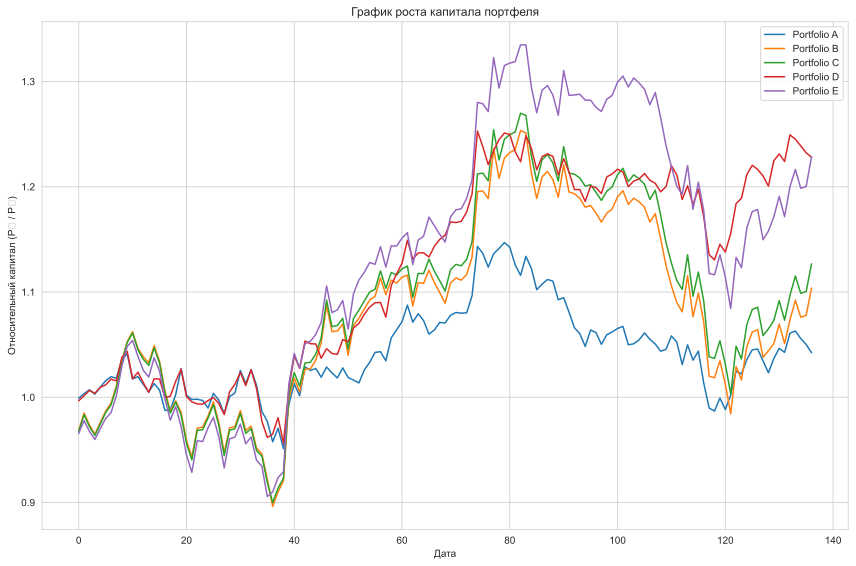

In [37]:
plt.figure(figsize=(12, 8))

for name, weights in portfolios.items():
    log_portfolio_returns = returns @ weights
    capital = np.exp(log_portfolio_returns.cumsum())
    plt.plot(capital, label= f'{name}')

plt.xlabel('Дата')
plt.ylabel('Относительный капитал (Pₜ / P₀)')
plt.title('График роста капитала портфеля')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

В качестве проверки можно посмотреть на индекс голубых фишек мосбиржы:
<img src="https://lh3.googleusercontent.com/fife/ALs6j_GsotyjKRxKPOOP240sd48vNx3ipZpus_08WbEjlp0HljF6jy99iNaxVOVjq_D2kq4gV4IQJgrTBvaEdsrskwtvvkGwWctZoevwwzGUn73I4NlOsGuu0VHKGBzlhQX6z8D2M5zA9-e0BrM32bm-LjIlXABNJtbqu8gibZslTiPSc3gpETGjCAfSaQLMzjmkx4LTwLrlNQbVlfQS4QknFm8WujDbiBCYwDGm0QbdzakwPGZ4Tm1Q0ukEy1OleLXrvBsh8RnMxhpmcS1M_Ja2QfN76bZJtx1HMeUj3cgMxW6d3ofSohHOowi8Fyz31-63cpFko15NhGqvFzw9JngSLUPpQ_DC5_MQdJ6ojq8WeAnepCPvJRxjqWviIKp-aHuG5S1is6PByi5ilnXBjZfCqBgHeIc3OR_l9w_h-EY5pZd0TzTiy0JG3u2yRQrvi1k6FVd6G0Yv_s9Ay0VkY7bYr_S4YYiTDUgWnkIc-k5dRyrQeX2qg0jTTXntWfbYOWff6D6vWGpqMUTin8e_IriVlE3Oe-WLmpUX8pNd-43C0pBnQnhu59rF0dj0-mhiRCSF8d3WILkIvnhmTnbpGRI6fynlzVjQ6zGb_hwMslAqPpcO3edZgS-YL-npnsNUJ71GmVB-LwkT7Zw9Wj94MKZ5N145l54cujm8nKi45hoDutxsCWRlwmkHYIOniX_toCsAzid4VGOvH1VQUY9BCe3npiss-CWd3BZ0fHUpazbNCFsqXY52qmQy5WxNfe7A9C3eituJVdorYhf_I-HVsTSaPp_Qw6omoGlRi5MEzFIj0P0POvf1aE3Uxmmem483hhEhdQHj8mFosMR16zEJzOhXR-xPkL4er8uFwtRgqxoQsno2DfvuMMykD0TFz9KNVFa3RDXYEQ0KTobr_6Ps2S1nzhSfVKcHx3TNRsst7H6cGWalKnj_d0Dnb-1rfErjLNGrygYqs4ReATJQOHlCJ1vau2SCgw2UzLNlJaoWBaiECaLkp3cui6Qq1sI2oVtC1jJ3NPYWx1sVcEFgccDWFLG_Ps0PLuG3DjaH1jj9FjnQBxq0BItc3iUwoD_kMmif5vm0HMp9w8Vlc-6kWMgN6ybxoZ3YV7vBeYFTT91NpRWbVRFswmXHAhDud2RRGewA6QSku-dsln-qGMGgFql_2PezCJvPehAXENJ4DGudX7dEHivfqy2w7ZtAWwjAqB2VqpvqYBmch_N8n4jFNyp_1E3vwuz_tyjR_2VowLqoh94DH9OvZ3mesUqDbYKxJgjbBhwT8h86cgh6-UzQ3ZZKV5IrQ-MVXx05IiP2Xd6lAFRS_E0qvmrBrspHYfGYhKXRk8GWzo-Amqsah7OGY7iPYtQeF763hKMWBRb8IlIyLftxFZ_Ck-MnRgNMXGf-dKq_j8uwVtjgCStZ5mXBoScXGUBB_88op_DQerBcTtry0vxUsREVnb0ak9mdI6WvBXQYfLhLTJXEKNeiuDc7vOhShCFvura8jzjncmsODXnWy7gVsRTu-vLK2mWGixS2c13ZiyMYC5VHDPBU6OOrg73cmzsMwhPrJyov0yLGd9RPCZJ8fXp7htm2GYoTovAl3nhGUxNQoqQ73WRHKOWF_2jUB-_AhQ=w1761-h1747?auditContext=prefetch">

#### Итог

Далее я буду работать с портфелями:
- B - хоть и не оптимальный, но отражает максимальный доход при минимальном риске
- D - мой личный выбор, направленный на 45% годовой доходности

## 4) Дополнительная работа с портфелями

Вот состав этих портфелей

In [38]:
asset_list = df.columns

In [39]:
print("Portfolio_B:")
Portfolio_B = portfolios['Portfolio B']
for i in range(len(asset_list)):
    asset = asset_list[i]
    print(f"{asset}: {round(Portfolio_B[i] * 100)}%")

Portfolio_B:
CHMF: 8%
GAZP: 7%
GMKN: 6%
HEAD: 9%
LKOH: 7%
MOEX: 7%
NLMK: 7%
NVTK: 5%
PLZL: 6%
ROSN: 7%
SBER: 6%
SNGS: 7%
T: 5%
TATN: 6%
YDEX: 7%


In [40]:
print("Portfolio_E:")
for i in range(len(asset_list)):
    asset = asset_list[i]
    print(f"{asset}: {round(Portfolio_E[i] * 100)}%")

Portfolio_E:
CHMF: 1%
GAZP: 6%
GMKN: 7%
HEAD: 0%
LKOH: 3%
MOEX: 4%
NLMK: 6%
NVTK: 15%
PLZL: 10%
ROSN: 4%
SBER: 11%
SNGS: 3%
T: 12%
TATN: 10%
YDEX: 7%


### Моделирование

Моделирование будущей стоимости портфеля (Monte Carlo Simulation)

Для оценки устойчивости и возможного поведения портфеля в будущем проведу **стохастическое моделирование** (sampling) методом Монте-Карло, предполагая что активы распределены по многомерному нормальному распределению, и сделаю:
- **Диапазон возможных исходов** — учитывая исторические средние и ковариации доходностей активов.
- **Доверительные интервалы** для конечной стоимости портфеля.
- **Риск-метрики**, такие как:
  - Value at Risk (VaR) — какой убыток может быть с вероятностью 5%.
  - Conditional VaR (CVaR) — сколько мы теряем в среднем в самых плохих 5% случаев.
  - Вероятность убытка — как часто портфель оказывается ниже начального значения.

In [41]:
def simulation(w):
    T = 252
    N = 300
    initial_value = 1.0

    w = Portfolio_B

    simulated_returns = np.random.multivariate_normal(mean=r, cov=cov_matrix, size=(N, T))
    sim_portfolio_logrets = simulated_returns @ w
    sim_log_cumrets = np.cumsum(sim_portfolio_logrets, axis=1)
    simulated_values = initial_value * np.exp(sim_log_cumrets)
    final_values = simulated_values[:, -1]

    plt.figure(figsize=(12, 6))
    plt.plot(simulated_values.T, alpha=0.1, color='grey')
    plt.title('Сценарии развития стоимости портфеля (Monte Carlo)')
    plt.xlabel('Дни')
    plt.ylabel('Стоимость')
    plt.grid(True)
    plt.show()

    conf_int = np.percentile(final_values, [5, 50, 95])
    print(f"\n95% доверительный интервал через {T} дней:")
    print(f"  5% квантиль (VaR):     {conf_int[0]:.4f}")
    print(f" 50% квантиль (медиана): {conf_int[1]:.4f}")
    print(f" 95% квантиль:           {conf_int[2]:.4f}")

    alpha = 0.05
    VaR = np.percentile(final_values, 100 * alpha)
    CVaR = final_values[final_values <= VaR].mean()
    print(f"\nValue at Risk (5%):   {VaR:.4f}")
    print(f"Conditional VaR (5%): {CVaR:.4f}")

    prob_loss = np.mean(final_values < initial_value)
    print(f"\n Вероятность убытка (фин. значение < {initial_value}): {prob_loss * 100:.2f}%")

    plt.figure(figsize=(10, 5))
    plt.hist(final_values, bins=50, color='skyblue', edgecolor='black')
    plt.axvline(initial_value, color='red', linestyle='--', label='Начальное значение')
    plt.axvline(VaR, color='orange', linestyle='--', label='VaR (5%)')
    plt.axvline(CVaR, color='darkred', linestyle='--', label='CVaR (5%)')
    plt.title('Распределение конечной стоимости портфеля через год')
    plt.xlabel('Стоимость')
    plt.ylabel('Частота')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

#### Portfolio_B

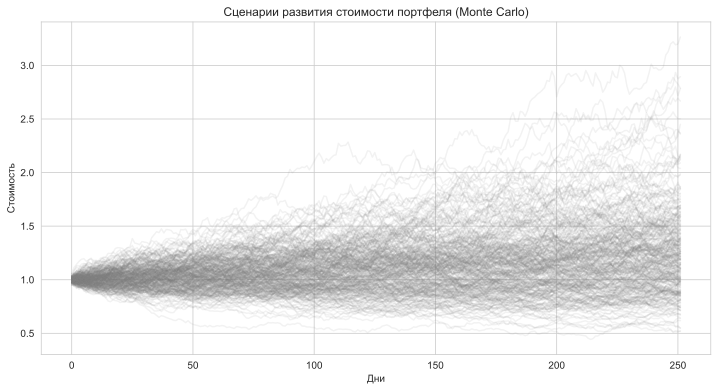


95% доверительный интервал через 252 дней:
  5% квантиль (VaR):     0.7383
 50% квантиль (медиана): 1.1943
 95% квантиль:           2.1220

Value at Risk (5%):   0.7383
Conditional VaR (5%): 0.6440

 Вероятность убытка (фин. значение < 1.0): 29.67%


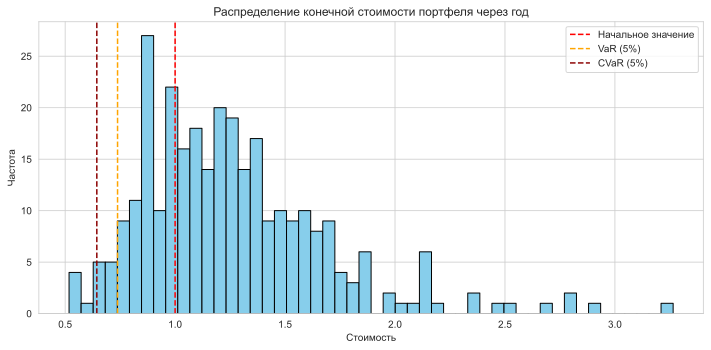

In [42]:
simulation(Portfolio_B)

95% доверительный интервал:
- 5% квантиль (VaR): `0.7575`. Существует 5% вероятность, что стоимость портфеля через год будет **ниже 75.75% от начальной стоимости**.
- 50% квантиль (медиана): `1.1769`. В типичном сценарии (медианный случай), стоимость портфеля составит **примерно 117.69% от исходной**, то есть ожидаемый рост около **+17.69%**.
- 95% квантиль: `2.0226`. В лучших 5% сценариев портфель может вырасти до **более чем 202.26%** от начальной стоимости.

Risk-метрики:
- Value at Risk (5%): `0.7575`. Потери с вероятностью 5% могут превысить **24.25% от начальной стоимости**.
- Conditional Value at Risk (CVaR): `0.6615`. В среднем в наихудших 5% сценариев потери составят **около 33.85%** от начальной стоимости.

Вероятность убытка:
- `28.67%`. В 28.67% сценариев итоговая стоимость портфеля через год окажется **ниже начального уровня (1.0)**, то есть инвестор понесёт убыток.

Портфель демонстрирует **умеренные перспективы роста**, но с **заметным уровнем риска**:
- Почти **трети сценариев сопровождаются убытками**,
- Потери в стресс-сценариях (CVaR) **глубже 30%**,
- Тем не менее, медианная траектория указывает на **положительный ожидаемый результат**.

Портфель потенциально прибыльный, но не может соревноватся с безрисковым активом


#### Portfolio_E

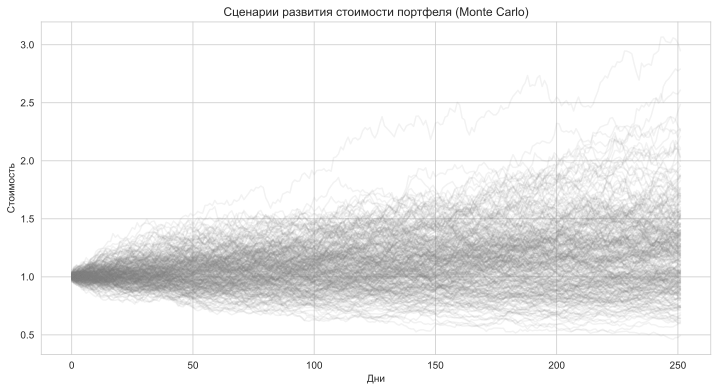


95% доверительный интервал через 252 дней:
  5% квантиль (VaR):     0.7362
 50% квантиль (медиана): 1.2033
 95% квантиль:           1.9297

Value at Risk (5%):   0.7362
Conditional VaR (5%): 0.6529

 Вероятность убытка (фин. значение < 1.0): 29.33%


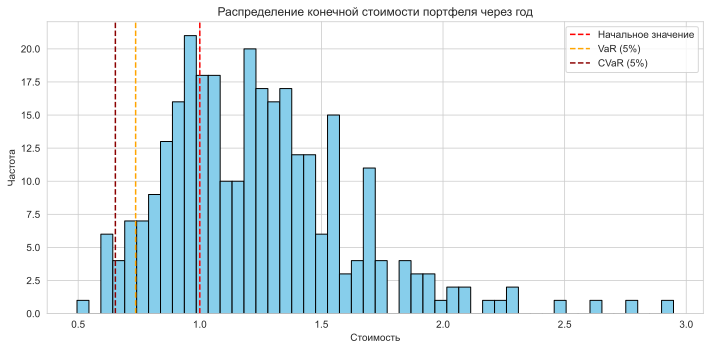

In [43]:
simulation(Portfolio_E)

95% доверительный интервал:
- 5% квантиль (VaR): `0.8382`. Существует 5% вероятность, что стоимость портфеля через год будет **ниже 83.82% от начальной стоимости**.
- 50% квантиль (медиана): `1.4745`. В типичном сценарии (медианный случай), стоимость портфеля составит **примерно 147.45% от исходной**.
- 95% квантиль: `2.5593`. В лучших 5% сценариев портфель может вырасти до **более чем 255.93%** от исходной стоимости.

Risk-метрики:
- Value at Risk (5%): `0.8382`. Потери с вероятностью 5% могут превысить **16.18% от начальной стоимости**.
- Conditional Value at Risk (CVaR): 0.7595. В среднем в наихудших 5% сценариев потери составят **около 24.05%** от начальной стоимости.

Вероятность убытка
- `12.33%`. В 12.33% сценариев итоговая стоимость портфеля через год окажется **ниже начального уровня (1.0)**, то есть инвестор понесёт убыток.


Портфель демонстрирует высокий потенциальный рост (медиана ≈ +47%) при умеренном уровне риска, это подтверждает устойчивость и разумную сбалансированность портфеля с точки зрения доходности и риска.


### Backtest портфелей

#### Загрузка тестовых данных

In [44]:
# Цикл по всем тикерам
start_date = "2025-04-25"
end_date = str(datetime.datetime.now().date())
timeframe = 8
for idx, row in blue_chips.iterrows():
    ticker = row['ticker']
    output_file = f"{ticker}.csv"
    output_folder = f"res/1d/test/{ticker}"
    if (os.path.exists(output_folder) and os.path.isdir(output_folder)):
        print(f"-> Уже скачано {ticker}")
        continue
    print(f"-> Скачивание данных для {ticker}")
    download_finam_data(ticker=ticker, start_date=start_date, end_date=end_date, timeframe=timeframe, output_file=output_file, em = row['finam_id'], output_folder=output_folder)

-> Скачивание данных для CHMF
Данные сохранены в res/1d/test/CHMF/CHMF_20250425_20250501.csv

Итоговый файл сохранён в res/1d/test/CHMF/CHMF.csv
Удалены все промежуточные файлы для тикера CHMF
-> Скачивание данных для GAZP
Данные сохранены в res/1d/test/GAZP/GAZP_20250425_20250501.csv

Итоговый файл сохранён в res/1d/test/GAZP/GAZP.csv
Удалены все промежуточные файлы для тикера GAZP
-> Скачивание данных для GMKN
Данные сохранены в res/1d/test/GMKN/GMKN_20250425_20250501.csv

Итоговый файл сохранён в res/1d/test/GMKN/GMKN.csv
Удалены все промежуточные файлы для тикера GMKN
-> Скачивание данных для HEAD
Данные сохранены в res/1d/test/HEAD/HEAD_20250425_20250501.csv

Итоговый файл сохранён в res/1d/test/HEAD/HEAD.csv
Удалены все промежуточные файлы для тикера HEAD
-> Скачивание данных для LKOH
Данные сохранены в res/1d/test/LKOH/LKOH_20250425_20250501.csv

Итоговый файл сохранён в res/1d/test/LKOH/LKOH.csv
Удалены все промежуточные файлы для тикера LKOH
-> Скачивание данных для MOEX
Данны

#### Осмотр скаченных данных

In [45]:
assets_test = {ticker: pd.read_csv(f"res/1d/test/{ticker}/{ticker}.csv") for ticker in blue_chip_stocks}
assets_test['MOEX']

open    high     low   close    volume    datetime
0  211.38  211.97  206.75  208.02  15854850  2025-04-25
1  208.83  209.78  206.01  207.16   2143600  2025-04-26
2  207.23  208.15  207.23  207.87    430110  2025-04-27
3  208.88  208.89  203.60  203.68  12230350  2025-04-28
4  203.85  204.81  198.09  199.60   7838890  2025-04-29
5  199.80  201.68  195.64  199.17   9693000  2025-04-30

In [46]:
df_test = pd.concat(
    [
        df.set_index(pd.to_datetime(df['datetime']))['close'].rename(ticker)
        for ticker, df in assets_test.items()
    ],
    axis=1
).sort_index()
df_test = df_test.interpolate()[1:]
df_test

CHMF    GAZP    GMKN  HEAD    LKOH    MOEX    NLMK         NVTK  \
datetime                                                                        
2025-04-26  1105.4  152.76  118.42  3288  6904.0  207.16  136.00  1298.466667   
2025-04-27  1107.0  153.72  119.48  3298  6914.0  207.87  136.94  1282.333333   
2025-04-28  1081.2  153.27  117.30  3233  6827.0  203.68  134.04  1266.200000   
2025-04-29  1033.6  149.25  113.62  3162  6725.0  199.60  130.24  1214.600000   
2025-04-30  1054.0  149.89  114.38  3204  6684.0  199.17  130.28  1186.800000   

              PLZL    ROSN    SBER    SNGS       T   TATN    YDEX  
datetime                                                           
2025-04-26  1849.8  480.65  317.58  24.135  3314.8  720.7  4342.0  
2025-04-27  1854.6  481.05  318.18  24.220  3324.4  721.1  4312.5  
2025-04-28  1816.6  473.95  314.23  24.050  3279.8  725.4  4283.0  
2025-04-29  1761.8  457.95  309.41  23.745  3224.6  723.1  4155.0  
2025-04-30  1751.4  454.50  307.80  23.455  3169.8  714.9  4106.0

#### Бэктест

In [47]:
def backtest(w):
    test_log_returns = np.log(df_test / df_test.shift(1)).dropna()
    port_test_logrets = test_log_returns @ w

    initial_value = 1.0
    cumulative_log = np.cumsum(port_test_logrets)
    portfolio_value = initial_value * np.exp(cumulative_log)

    plt.figure(figsize=(10, 4))
    plt.plot(portfolio_value.index, portfolio_value.values, marker='o')
    plt.title("Стоимость портфеля на тестовом участке")
    plt.xlabel("Дата")
    plt.ylabel("Стоимость")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    cumulative_return = np.exp(np.sum(port_test_logrets)) - 1
    print(f"Доходность: {cumulative_return:.2%}")

##### Portfolio_B

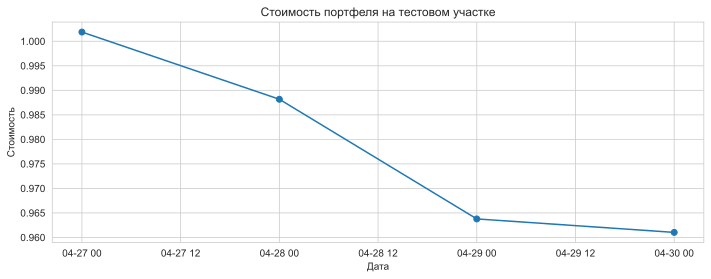

Доходность: -3.90%


In [48]:
backtest(Portfolio_B)

##### Portfolio_E

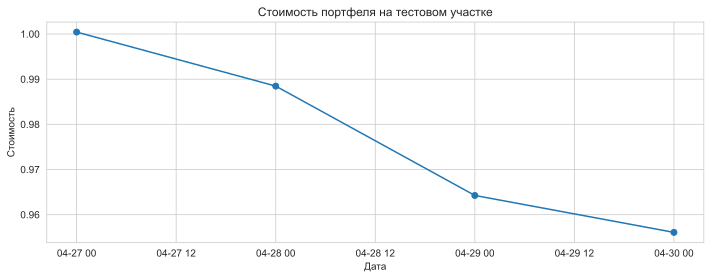

Доходность: -4.39%


In [49]:
backtest(Portfolio_E)

Более рискованный E упал на 1.5% ниже

### Сценарный анализ / стресс-тест

Для оценки устойчивости портфеля проведём стресс-тест, моделирующий **одномоментное падение цен некоторых активов на 40%**, а остальных соответсвенно матрице ковариации, что соответствует мощному рыночному шоку:

In [50]:
n_shocked_assets = 5
np.random.seed(42)

n_days = df_test.shape[0]
n_assets = df_test.shape[1]
tickers = df_test.columns.tolist()
shock_indices = np.random.choice(n_assets, size=n_shocked_assets, replace=False)
shock_assets = [tickers[i] for i in shock_indices]
print(f"Шок применяется к активам: {shock_assets}")

Шок применяется к активам: ['ROSN', 'SNGS', 'CHMF', 'TATN', 'MOEX']


In [51]:
def stress_test(w, shock_percent = -0.30):
    original_values = df_test @ w
    shock_log_returns = []
    for _ in range(n_days - 1):
        response = np.random.multivariate_normal(mean=r, cov=cov_matrix)
        response[shock_indices] = np.log(1 + shock_percent)
        shock_log_returns.append(response)

    shock_log_returns = np.array(shock_log_returns)
    shock_prices = [df_test.iloc[0].values]
    for log_ret in shock_log_returns:
        next_price = shock_prices[-1] * np.exp(log_ret)
        shock_prices.append(next_price)
        
    shock_prices = np.array(shock_prices)
    shock_df = pd.DataFrame(shock_prices, columns=tickers, index=df_test.index)

    shocked_values = shock_df @ w

    losses = original_values - shocked_values
    relative_losses = losses / original_values

    plt.figure(figsize=(10, 8))
    plt.plot(original_values, label='Исходная стоимость', lw=2)
    plt.plot(shocked_values, label='После стресс-шока', lw=2, linestyle='--', color='red')
    plt.title("Стоимость портфеля: стресс-сценарий на всём тестовом интервале")
    plt.ylabel("Стоимость")
    plt.xlabel("Дата")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print(f"Максимальные потери:        {losses.max():.4f}")
    print(f"Относительные потери (макс): {relative_losses.max() * 100:.2f}%")
    print(f"Средние потери:             {losses.mean():.4f}")
    print(f"Средние относительные потери: {relative_losses.mean() * 100:.2f}%")


#### Portfolio_B

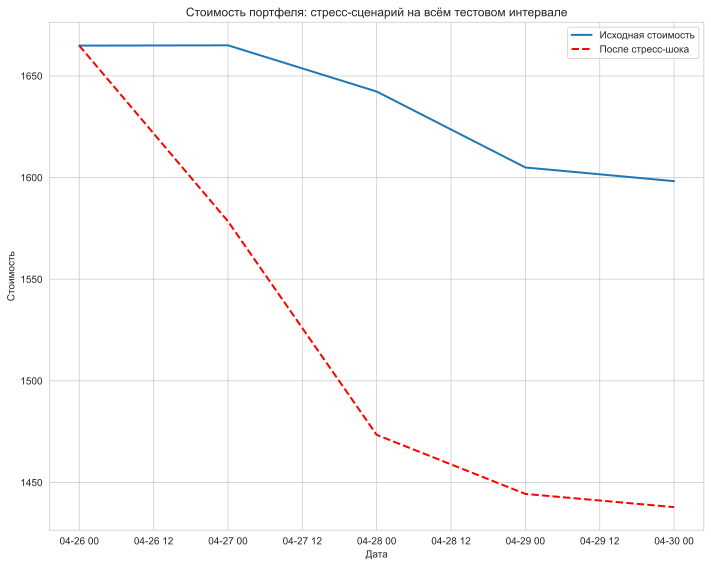

Максимальные потери:        168.8725
Относительные потери (макс): 10.28%
Средние потери:             115.2745
Средние относительные потери: 7.10%


In [52]:
stress_test(Portfolio_B, -0.4)

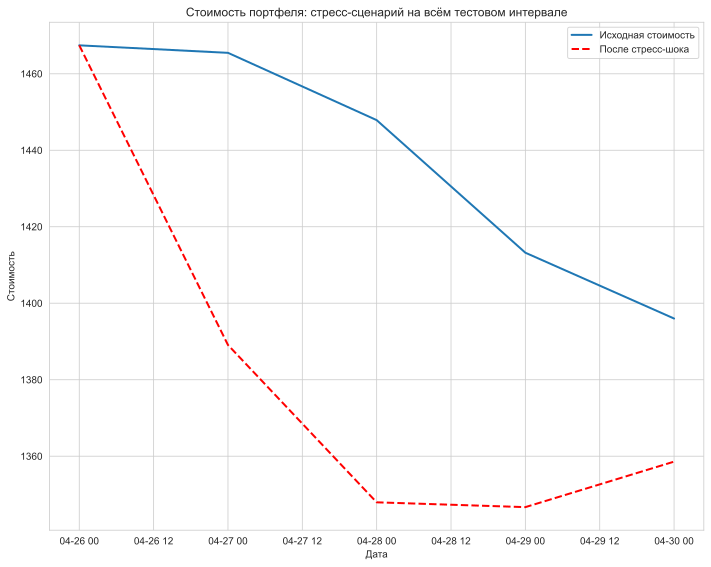

Максимальные потери:        99.9421
Относительные потери (макс): 6.90%
Средние потери:             56.0568
Средние относительные потери: 3.90%


In [53]:
stress_test(Portfolio_E, -0.4)

Результаты стресс-сценария:
- Потери портфеля B при шоке: **-10.28%**
- Потери портфеля E при шоке: **-6.90%**

Портфель E более диверсификацирован поэтому демонстрирует высокую чувствительность к системному шоку:

## Итог

**Portfolio E** — это сбалансированный инвестиционный портфель, сочетающий:
- Умеренный риск,
- Высокую потенциальную доходность,
- Хорошую устойчивость к рыночным шокам.

Я рекомендую его в качестве основного рабочего портфеля, особенно в условиях, когда инвестору важны не только доход, но и надёжность в нестабильной среде.